In [1]:
import torch
import pickle
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# dump_file = "../data/processed/sbert_embeddings.dat"
# with open(dump_file, "rb") as f:
#     embeddings = pickle.load(f)

# print(embeddings.shape)

In [3]:
## read in the dataset
df = pd.read_csv("../data/stimuli_idioms_clean.csv")
# dataset = df[["item"]]
# norm_freq_en = df["fitem"]

# get the previously calculated embeddings from the file in which they were stored
# requires running run_one_experiment.py or run_all_experiments.py first
embeddings_cache_filename = "../data/processed/sbert_stimuli_idioms_clean-last_1-kwics-concat.dat"
with open(embeddings_cache_filename, "rb") as colloc2BERTfile:
    colloc_embeddings = pickle.load(colloc2BERTfile)

In [4]:
collocs = list(colloc_embeddings.keys())
embeddings = torch.stack([colloc_embeddings[colloc]["vec"] for colloc in collocs])

# norm embeddings (same as in run_one_experiment.py)
embeddings = (embeddings - embeddings.mean()) / embeddings.std()

print(embeddings.shape)
colloc_embeddings = pd.DataFrame(
    {
        "item": collocs,
        "vec": embeddings.tolist(),
    }
)
colloc_embeddings

torch.Size([246, 768])


,item,vec
0,abandon ship,"[0.6813992857933044, 0.6821767687797546, 2.079..."
1,battle demon,"[0.28214821219444275, 0.708100438117981, 0.367..."
2,beat drum,"[1.1023974418640137, 0.3866420090198517, 1.302..."
3,bend knee,"[0.0939703956246376, 1.617830753326416, -1.054..."
4,blow smoke,"[1.4555710554122925, 0.6088924407958984, 1.256..."
...,...,...
241,fuel passion,"[0.11440841853618622, 0.43344083428382874, 0.4..."
242,fan fear,"[0.5318445563316345, 0.07368212193250656, 0.18..."
243,sweeten deal,"[-0.12492208182811737, 0.14423401653766632, 0...."
244,close case,"[0.5094650387763977, 0.1782718300819397, 0.642..."


In [5]:
df_expanded = df.merge(colloc_embeddings, on="item")
df_expanded

,item,fitem,score,type,verb,noun,vec
0,abandon ship,16629.0,7.9,idiom,abandon,ship,"[0.6813992857933044, 0.6821767687797546, 2.079..."
1,battle demon,4244.0,8.0,idiom,battle,demon,"[0.28214821219444275, 0.708100438117981, 0.367..."
2,beat drum,15198.0,8.0,idiom,beat,drum,"[1.1023974418640137, 0.3866420090198517, 1.302..."
3,bend knee,27701.0,10.5,idiom,bend,knee,"[0.0939703956246376, 1.617830753326416, -1.054..."
4,blow smoke,11725.0,8.6,idiom,blow,smoke,"[1.4555710554122925, 0.6088924407958984, 1.256..."
...,...,...,...,...,...,...,...
241,fuel passion,4510.0,7.0,collocation,fuel,passion,"[0.11440841853618622, 0.43344083428382874, 0.4..."
242,fan fear,846.0,7.4,collocation,fan,fear,"[0.5318445563316345, 0.07368212193250656, 0.18..."
243,sweeten deal,8402.0,6.5,collocation,sweeten,deal,"[-0.12492208182811737, 0.14423401653766632, 0...."
244,close case,27515.0,6.5,collocation,close,case,"[0.5094650387763977, 0.1782718300819397, 0.642..."


In [6]:
def get_sampled_matrix(embeddings, frequencies, M=10000, forget_prob=0.6, seed=None):
    assert embeddings.size(0) == len(frequencies)
    n_items, embed_dim = embeddings.shape
    # print(f"\nSeed {s}\n")
    random_generator = random.Random(seed)
    torch_generator = torch.Generator().manual_seed(seed)

    # sample from the collocations to make a M x 768 matrix
    sample_k = M - len(embeddings)

    # if do_equal_frequency:
    #     sampled_collocs = torch.stack(
    #         random_generator.choices(colloc_bert_embeddings, k=sample_k)
    #     )
    # else:

    # sampled_collocs = torch.stack(
    #     random_generator.choices(embeddings, k=sample_k, weights=frequencies)
    # )

    # sample our original items once, and the rest from the distribution
    sampled_freqs = torch.cat(
        (
            torch.arange(n_items),
            torch.multinomial(item_freq, sample_k, replacement=True),
        )
    )
    matrix = embeddings[sampled_freqs]

    # matrix = torch.concat([embeddings, sampled_collocs], dim=0)

    assert matrix.size() == (M, embed_dim), "Huh?"

    # TODO: document noise procedure
    # again, why is noising per dimension so different?
    noise_mean = torch.tensor([0.0]).expand(M, embed_dim)
    noise_std = (
        matrix.std().expand(M, embed_dim) / 2
    )  # tie noise to the std of the matrix

    print(f"Noising with std {noise_std.mean()}")
    noise_gaussian = torch.normal(noise_mean, noise_std, generator=torch_generator)
    noise_mask = torch.rand((M, embed_dim), generator=torch_generator)
    noisy_mem = torch.where(
        noise_mask < forget_prob, matrix + noise_gaussian, matrix
    )  # if the noise is less than L, then add gaussian noise, otherwise it is the original matrix
    # noisy_mem = torch.where(
    #     noise_mask < L, 0.0, matrix
    # )  # if the noise is less than L, then add gaussian noise, otherwise it is the original matrix
    return noisy_mem, sampled_freqs


DO_LOG_FREQ = False

item_embeddings = torch.tensor(df_expanded["vec"].tolist())
item_freq = torch.tensor(df_expanded["fitem"].tolist())
if DO_LOG_FREQ:
    item_freq = torch.log10(item_freq)

sampled_matrix, sampled_items = get_sampled_matrix(
    item_embeddings,
    item_freq,
    M=10000,
    forget_prob=0.6,
    seed=0,
)
print(f"{sampled_matrix.shape=}")
print(f"{sampled_items.shape=}")

Noising with std 0.5012455582618713
sampled_matrix.shape=torch.Size([10000, 768])
sampled_items.shape=torch.Size([10000])


In [7]:
def get_query_sims(query_vectors, matrix):
    """
    Get pairwise cosine similarities between query vectors and a matrix of vectors.
    """
    sims = [
        torch.cosine_similarity(v.unsqueeze(0), matrix, dim=-1) for v in query_vectors
    ]
    return torch.stack(sims)

print(item_embeddings.shape, sampled_matrix.shape)

probe_matrix_sims = get_query_sims(item_embeddings, sampled_matrix)
print(probe_matrix_sims.shape)

torch.Size([246, 768]) torch.Size([10000, 768])
torch.Size([246, 10000])


torch.Size([246, 246])


<Axes: >

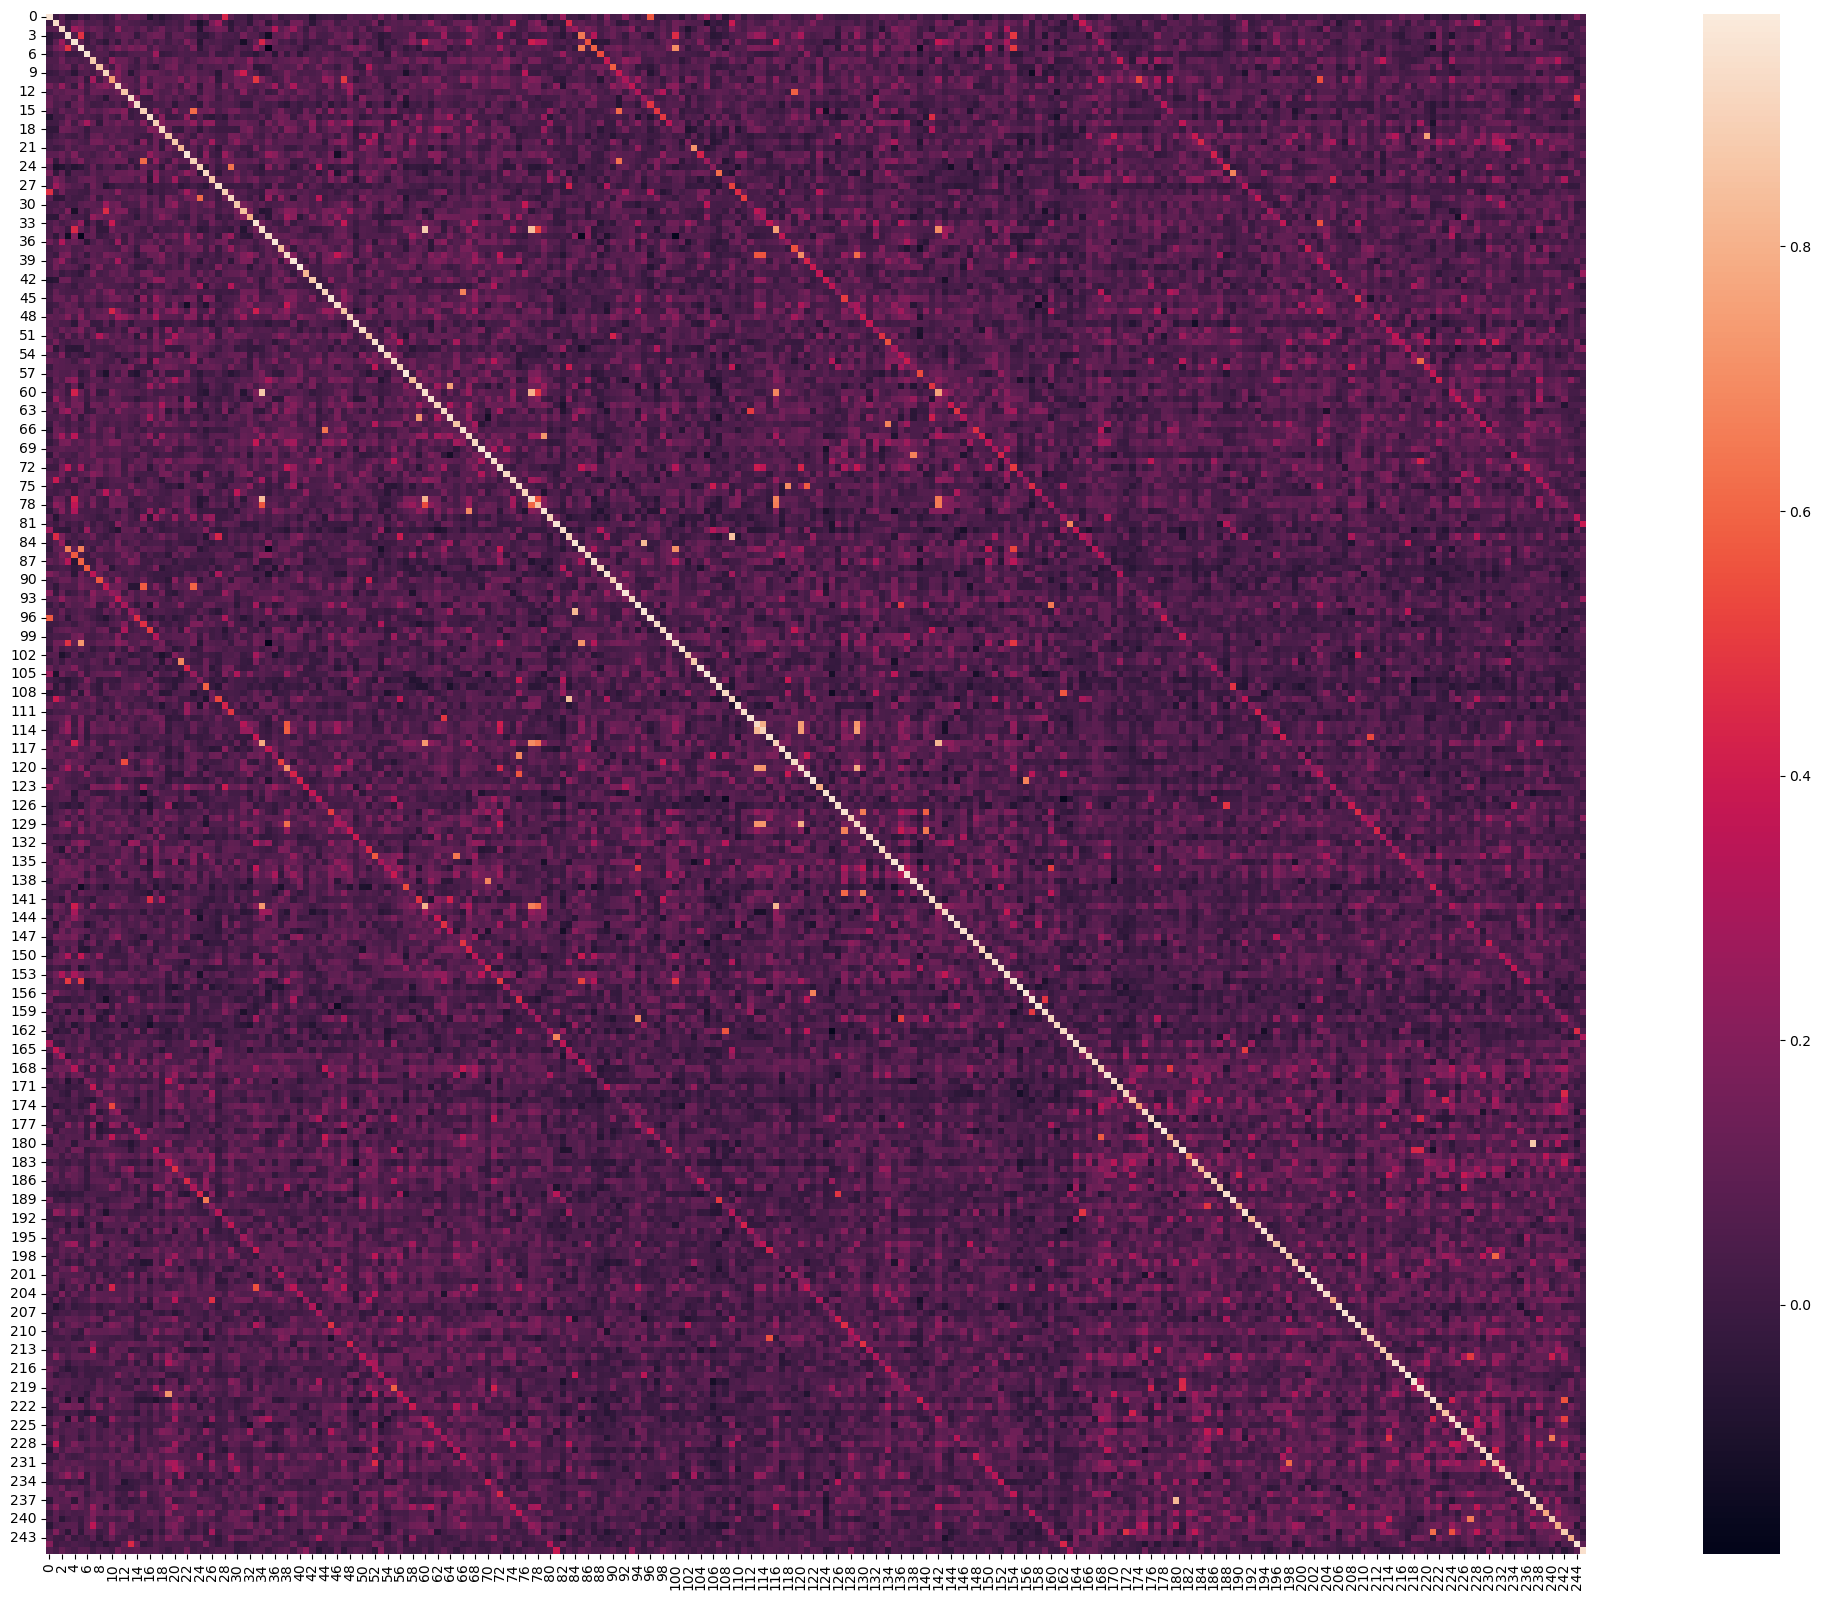

In [8]:
n_items = len(item_embeddings)

pairwise_agg_sims = torch.zeros(n_items, n_items)

data = []

for i in range(n_items):
    for j in range(n_items):
        where_j = sampled_items == j
        item_i = df_expanded.iloc[i]["item"]
        type_i = df_expanded.iloc[i]["type"]
        item_j = df_expanded.iloc[j]["item"]
        type_j = df_expanded.iloc[j]["type"]
        mean_sim = probe_matrix_sims[i, where_j].mean()

        data.append(
            {
                "item_i": item_i,
                "type_i": type_i,
                "item_j": item_j,
                "type_j": type_j,
                "mean_sim": mean_sim.item(),
            }
        )

        pairwise_agg_sims[i, j] = mean_sim

print(pairwise_agg_sims.shape)

# torch.zeros(246, 246).scatter_add_(0, sampled_items.unsqueeze(0), probe_matrix_sims)

fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(pairwise_agg_sims, ax=ax, square=True)

In [9]:
df_agg_sims = pd.DataFrame(data)
df_agg_sims

,item_i,type_i,item_j,type_j,mean_sim
0,abandon ship,idiom,abandon ship,idiom,0.960425
1,abandon ship,idiom,battle demon,idiom,0.000144
2,abandon ship,idiom,beat drum,idiom,0.071316
3,abandon ship,idiom,bend knee,idiom,-0.040912
4,abandon ship,idiom,blow smoke,idiom,-0.043122
...,...,...,...,...,...
60511,run country,collocation,fuel passion,collocation,0.055570
60512,run country,collocation,fan fear,collocation,-0.067339
60513,run country,collocation,sweeten deal,collocation,0.002499
60514,run country,collocation,close case,collocation,0.085871


In [17]:
df_agg_sims.to_csv("../data/processed/sbert_stimuli_idioms_clean-last_1-kwics-concat-sims.csv", index=False)

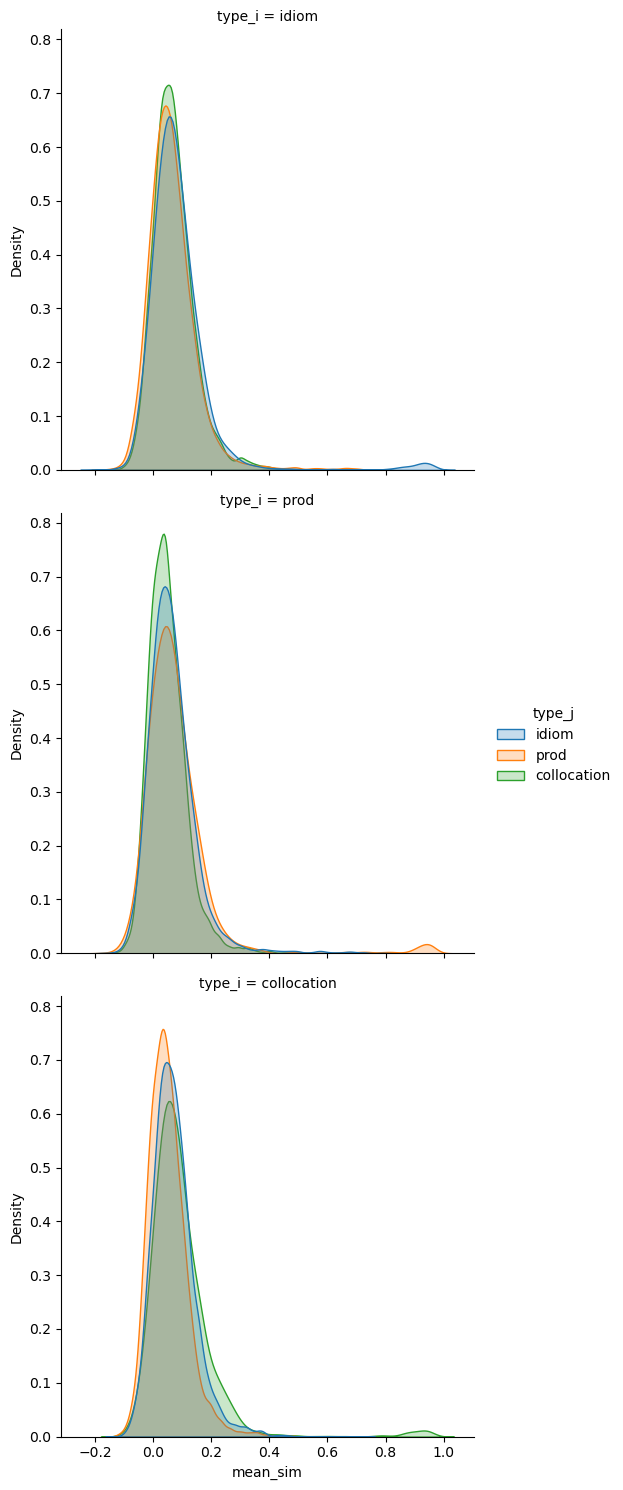

In [23]:
# plot mean similarity by type_i and type_j
_sims = df_agg_sims.copy()
# _sims["mean_sim"] = _sims["mean_sim"]
sns.displot(
    _sims,
    x="mean_sim",
    row="type_i",
    hue="type_j",
    kind="kde",
    fill=True,
    # bw_adjust=0.25,
    # log_scale=(False, True),
)

<Axes: xlabel='type_i', ylabel='mean_sim'>

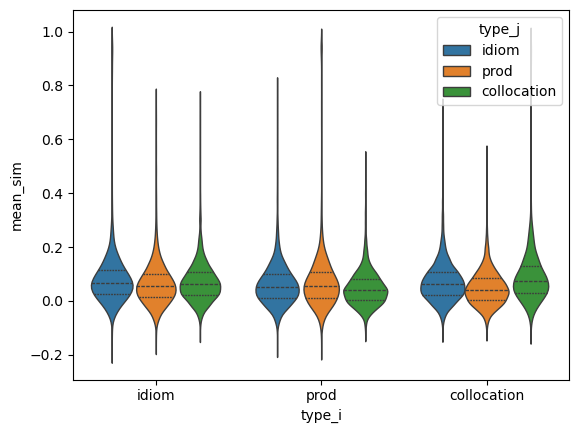

In [22]:
# violin plots
sns.violinplot(
    data=_sims,
    x="type_i",
    y="mean_sim",
    hue="type_j",
    inner="quart",
    linewidth=1,
)

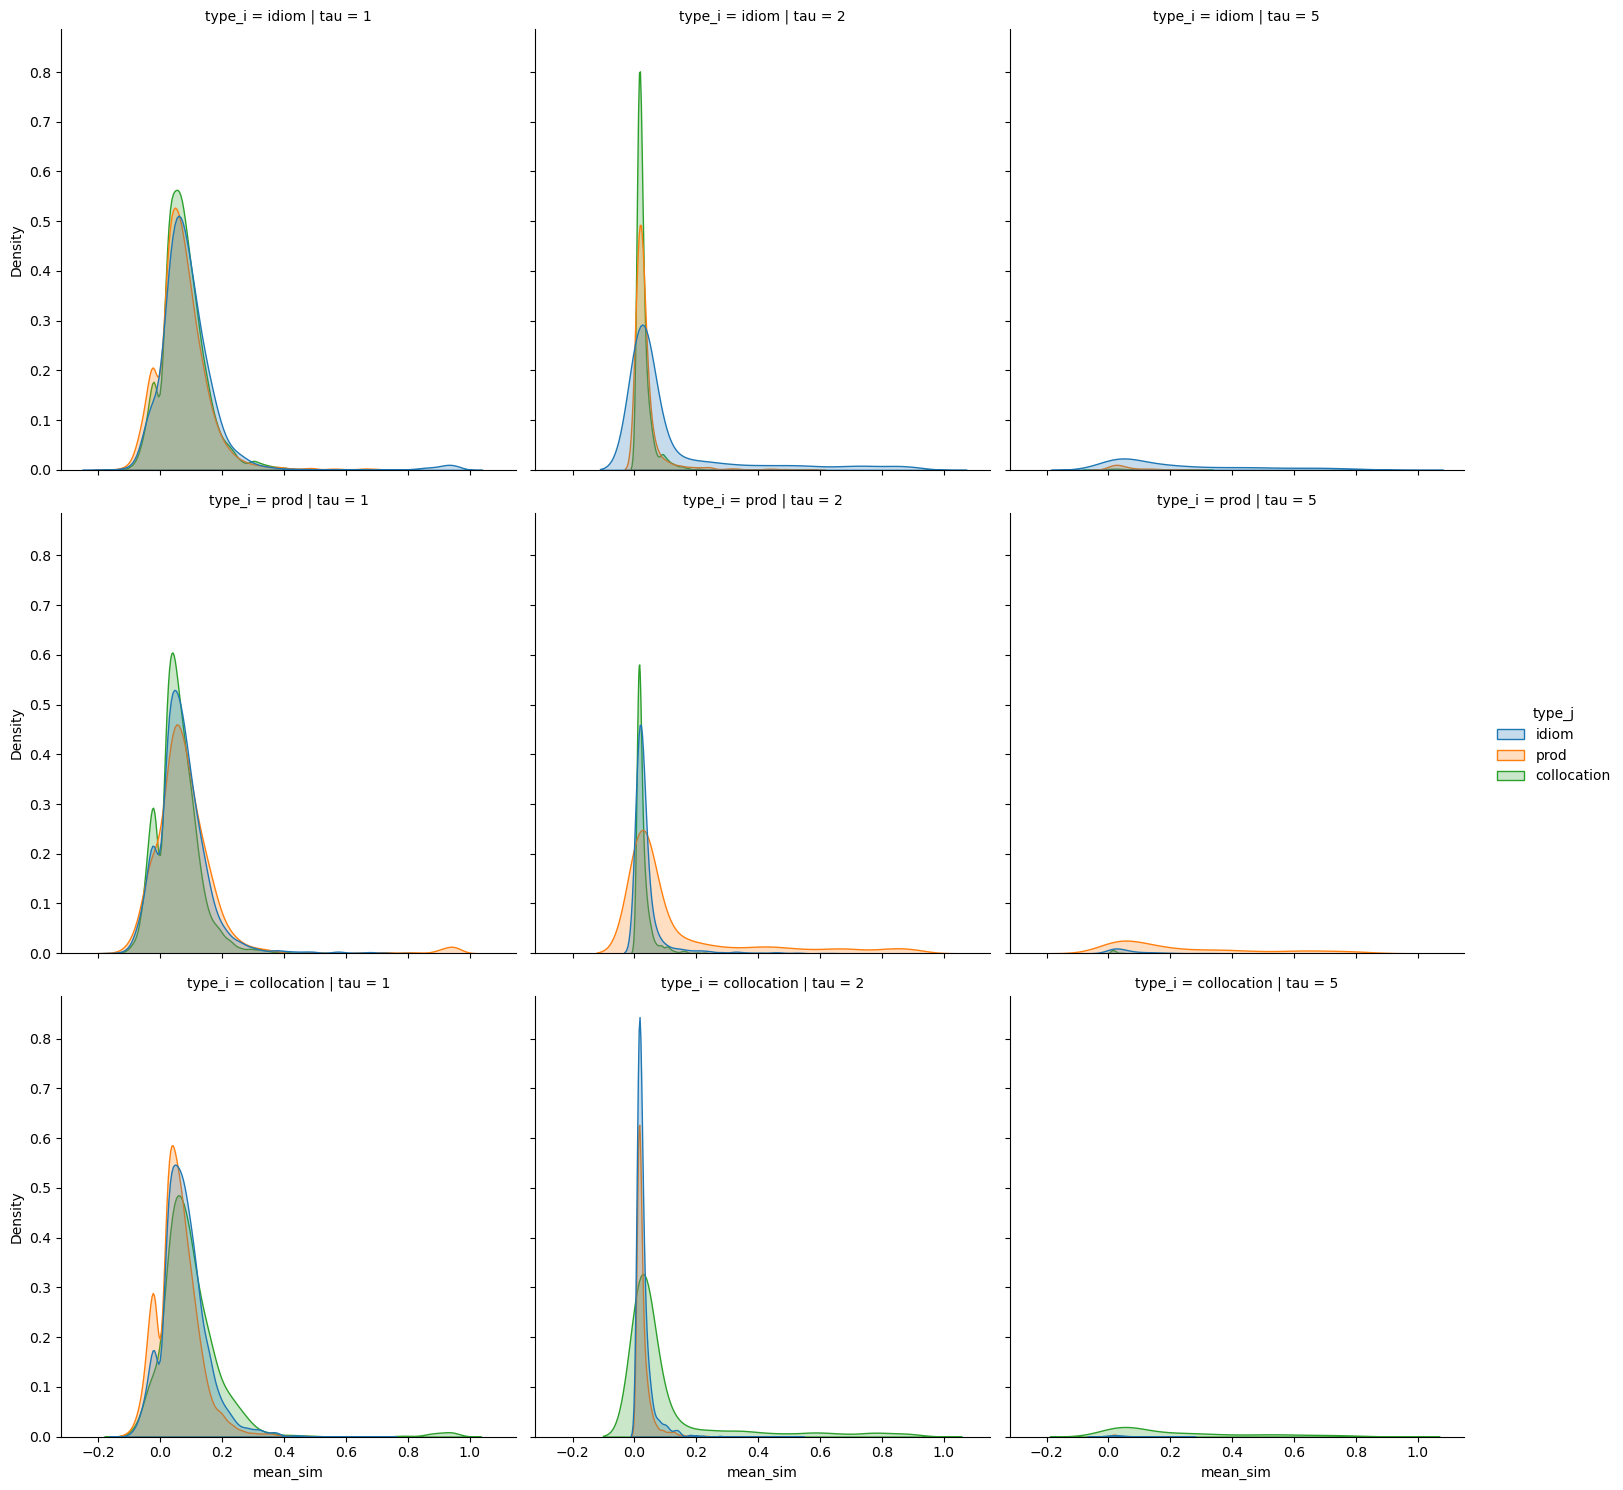

In [31]:
_simstau1 = df_agg_sims.copy()
_simstau1["tau"] = 1

_simstau2 = _sims.copy()
_simstau2["tau"] = 2
_simstau2["mean_sim"] = _sims["mean_sim"] ** 2

_simstau5 = _sims.copy()
_simstau5["tau"] = 5
_simstau5["mean_sim"] = _sims["mean_sim"] ** 5

_sims = pd.concat([_simstau1, _simstau2, _simstau5])

# _sims["mean_sim_tau2"] = _sims["mean_sim"] ** 2
# _sims = _sims[abs(_sims["mean_sim_tau2"]) > 0.01]
# _sims["mean_sim_tau5"] = _sims["mean_sim"] ** 5
# _sims = _sims[abs(_sims["mean_sim_tau5"]) > 0.01]
# _sims["mean_sim_tau10"] = _sims["mean_sim"] ** 5
# _sims = _sims[abs(_sims["mean_sim_tau5"]) > 0.01]

# _sims["mean_sim"] = _sims["mean_sim"]
sns.displot(
    _sims[abs(_sims["mean_sim"]) > 0.01],
    x="mean_sim",
    row="type_i",
    col="tau",
    hue="type_j",
    kind="kde",
    fill=True,
    # bw_adjust=0.25,
    # log_scale=(False, True),
)

In [15]:
# typewise agg sims

# get the type of each item
item_types = df_expanded["type"].unique()
n_per_type = df_expanded["type"].value_counts()[item_types[0]]

type_agg_sims = torch.zeros(len(item_types), len(item_types), n_per_type)

for i, t1 in enumerate(item_types):
    for j, t2 in enumerate(item_types):
        where_t1 = df_expanded["type"] == t1
        where_t2 = df_expanded["type"] == t2
        type_agg_sims[i, j] = pairwise_agg_sims[where_t1][:, where_t2].mean(dim=0)

type_agg_sims.shape

# sns.heatmap(pairwise_agg_sims, xticklabels=item_types, yticklabels=item_types)

torch.Size([3, 3, 82])